In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import utils
import skutils
import pandas as pd

TRAIN_DATA = "../../data/train.csv"
TEST_DATA = "../../data/test.csv"

# Load the training data
train = pd.read_csv(TRAIN_DATA)

# Load the testing data
test = pd.read_csv(TEST_DATA)

In [2]:
# Get importance
importances = skutils.feature_importance(train.drop(['ID', 'TARGET'], axis=1), train['TARGET'])

# Get uniques
uniques = train.apply(lambda x: len(x.unique()))

def transform(data, threshold_unimportant=0.0000001):
    
    cols_emtpy = list(uniques[uniques == 1].index.values)
    
    # We have to remove the correlated ones by hand
    # because there can be multiple correlations with one column
    cols_correlated = [
        'ind_var1', 'ind_var1_0',
        'ind_var5',
        'ind_var6', 'ind_var6_0', 'num_var6',
        'ind_var8', 'ind_var8_0',
        'ind_var12',
        'ind_var13_corto', 'ind_var13_corto_0', 'ind_var13_medio', 'ind_var13_medio_0',
        'ind_var18', 'ind_var18_0', 'num_var18', 'num_var18_0',
        'ind_var20', 'ind_var20_0',
        'ind_var29', 'ind_var29_0',
        'ind_var24', 'ind_var24_0',
        'ind_var25_0', 'num_var25_0',
        'ind_var26_0', 'num_var26_0',
        'ind_var32_0', 'num_var32_0',
        'ind_var34', 'ind_var34_0', 'num_var34', 'num_var34_0',
        'ind_var37_0', 'num_var37_0',
        'ind_var39',
        'ind_var40', 'num_var40',
        'ind_var44',
        'num_var29_0',
        'num_var13_medio', 'num_var13_medio_0',
        'num_var7_emit_ult1',
        'num_var39',
        'num_var40_0',
        'num_var44_0',
        'saldo_var6',
        'saldo_var18',
        'saldo_var13_medio',
        'saldo_medio_var17_ult3',
        'saldo_medio_var33_ult1',
        'delta_imp_aport_var13_1y3', 'delta_imp_reemb_var13_1y3', 'delta_num_reemb_var13_1y3',
        'delta_imp_aport_var17_1y3', 'delta_imp_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3',
        'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var33_out_1y3',
        'delta_imp_compra_var44_1y3', 'delta_imp_venta_var44_1y3',
        'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
        'delta_imp_trasp_var33_in_1y3', 'delta_imp_trasp_var33_out_1y3',
        'imp_reemb_var17_hace3',
        'imp_reemb_var33_ult1', 'imp_trasp_var33_out_ult1',
        'num_med_var45_ult3',
        'imp_op_var39_efect_ult1',
        'imp_op_var39_efect_ult3',
        'imp_op_var39_ult1',
        'imp_amort_var18_ult1',
        'saldo_medio_var17_hace3', 'saldo_medio_var17_ult1',
        'saldo_medio_var13_medio_ult3',
    ]
    
    cols_irrelevant = list(importances[importances.importance < threshold_unimportant].column.values)
    
    # Extract the ids
    ids = data['ID']
    
    # Extract the data
    X = data.drop(['ID'] + cols_emtpy + cols_correlated + cols_irrelevant,  axis=1)
    if 'TARGET' in data.columns:
        X.drop('TARGET', axis=1, inplace=True)

    # Extract the labels
    y = data['TARGET'] if 'TARGET' in data.columns else None
    
    return ids, X, y

# Create Test Dataset

In [3]:
from sklearn.cross_validation import StratifiedShuffleSplit

# Transform the training data
Ids_train, X, y = transform(train)

sss = StratifiedShuffleSplit(y, random_state=2, n_iter=30, test_size=0.15)

for train_index, test_index in sss:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Create a XGB Classifier

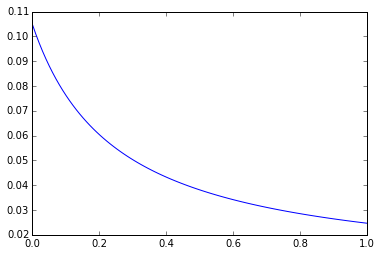

In [8]:
# Learning Rate
learning_rate = lambda _steps: 0.01 / np.log1p(np.linspace(0.1, 0.5, _steps))
steps = 100
fig = plt.figure()
plt.plot(np.linspace(0, 1, steps), learning_rate(steps))

In [22]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
import numpy as np

params = {
    'max_depth': 3,
    'n_estimators': 250,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'seed': 42,
}

fit_params = {
    'early_stopping_rounds': 20,
    'eval_metric': 'auc',
    'eval_set': [(X_test.values, y_test.values)],
    'learning_rates': lambda i, n: learning_rate(n)[i],
}

# eval_set: set that is used for watching the training performance

# learing_rates: sets the eta parameter for each boost round
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md#parameters-for-tree-booster
# lambda i, n: np.linspace(0.4, 0.2, n)[i] # Linear learning rate decay

clf = xgb.XGBClassifier(**params)

# Cross Validate XGB

In [23]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

nrounds = params['n_estimators']
folds = skutils.folds(y_train, n_folds=4, stratified=True, random_state=params['seed'])

# Needs latest XGBoost from chaosmail
# https://github.com/chaosmail/xgboost
# https://github.com/dmlc/xgboost/blob/master/doc/build.md
scores = xgb.cv(params, xgb.DMatrix(X_train, y_train), nrounds, metrics=['auc'], maximize=True, 
                early_stopping_rounds=fit_params['early_stopping_rounds'], folds=folds)

print("Cross validation test-auc-mean score %.8f (+- %.8f)" 
      % (scores['test-auc-mean'].ix[len(scores) - 1], scores['test-auc-std'].ix[len(scores) - 1]))

print("Cross validation train-auc-mean score %.8f (+- %.8f)"
      % (scores['train-auc-mean'].ix[len(scores) - 1], scores['train-auc-std'].ix[len(scores) - 1]))

Cross validation test-auc-mean score 0.83415550 (+- 0.00727635)
Cross validation train-auc-mean score 0.85977475 (+- 0.00219465)


/home/ckoerner/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


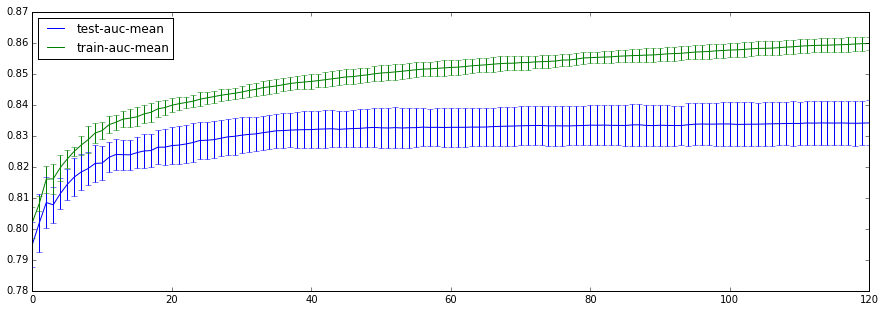

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(15, 5), dpi=120)
scores[['test-auc-mean', 'test-auc-std']].plot(yerr='test-auc-std', ax=ax)
scores[['train-auc-mean', 'train-auc-std']].plot(yerr='train-auc-std', ax=ax)

# Compute Private Score

In [12]:
from sklearn.metrics import roc_auc_score

clf.fit(X_train.values, y_train.values, **fit_params)

score = roc_auc_score(y_test.values, clf.predict_proba(X_test.values, ntree_limit=clf.best_iteration)[:,1])

print("Private Score %.8f" % score)

Will train until validation_0 error hasn't decreased in 20 rounds.

[0]	validation_0-auc:0.799755

[1]	validation_0-auc:0.805065

[2]	validation_0-auc:0.807074

[3]	validation_0-auc:0.808071

[4]	validation_0-auc:0.807301

[5]	validation_0-auc:0.808640

[6]	validation_0-auc:0.808408

[7]	validation_0-auc:0.809981

[8]	validation_0-auc:0.809794

[9]	validation_0-auc:0.809892

[10]	validation_0-auc:0.810689

[11]	validation_0-auc:0.811805

[12]	validation_0-auc:0.814073

[13]	validation_0-auc:0.812410

[14]	validation_0-auc:0.813720

[15]	validation_0-auc:0.813598

[16]	validation_0-auc:0.813892

[17]	validation_0-auc:0.814206

[18]	validation_0-auc:0.814792

[19]	validation_0-auc:0.814554

[20]	validation_0-auc:0.814765

[21]	validation_0-auc:0.815012

[22]	validation_0-auc:0.814622

[23]	validation_0-auc:0.814583

[24]	validation_0-auc:0.814333

[25]	validation_0-auc:0.814830

[26]	validation_0-auc:0.814762

[27]	validation_0-auc:0.814493

[28]	validation_0-auc:0.814964

[29]	validatio

# Make Submission

In [ ]:
Ids_test_, X_test_, y_test_ = transform(test)

clf.fit(X.values, y.values, **fit_params)

y_pred = clf.predict_proba(X_test_.values, ntree_limit=clf.best_iteration)

submission = pd.DataFrame({"ID":Ids_test_, "TARGET":y_pred[:,1]})
submission.to_csv("submission_%s.csv" % utils.timestamp(), index=False)

# Public Score: 0.837660